<a href="https://colab.research.google.com/github/Pyeonseohee/Deeplearning/blob/main/Deepnoid_Lecture09_CycleGAN_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# CycleGAN 구현 코드



In [1]:
from __future__ import print_function, division
import tensorflow as tf
!pip install tensorflow-addons
import tensorflow_datasets as tfds
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
import scipy
from keras.datasets import mnist
from tensorflow_addons.layers import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import datetime
import sys, glob
import os
import cv2
import random

     |████████████████████████████████| 706kB 17.6MB/s 


# Train, Test Dataset을 구성하는 로더

In [2]:
class DataLoader():
    def __init__(self, dataset, img_res):
        self.img_res = img_res
        self.dataset = dataset
        

    def load_data(self, domain, batch_size=1, is_testing=False):
        data_type = "train%s" % domain if not is_testing else "test%s" % domain
        image = self.dataset[data_type]
        imgs = self.extract_image(image,is_testing)
        number = list(range(1, imgs.shape[0]))
        random.shuffle(number)
        return imgs[number[0:batch_size]]

    def load_batch(self, batch_size=1, is_testing=False):
        horses = self.dataset['trainA']
        train_horses = self.extract_image(horses,is_testing)

        zebras = self.dataset['trainB']
        train_zebras = self.extract_image(zebras,is_testing)

        self.n_batches = int(min(len(train_horses), len(train_zebras)) / batch_size)
        total_samples = self.n_batches * batch_size

        # Sample n_batches * batch_size from each path list so that model sees all
        # samples from both domains

        for i in range(self.n_batches-1):
            print('total: %d, now: %d' %(self.n_batches, i))
            imgs_A = train_horses[i*batch_size:(i+1)*batch_size]
            imgs_B = train_zebras[i*batch_size:(i+1)*batch_size]

            yield imgs_A, imgs_B

    def extract_image(self, image, is_testing):
        imgs = []
        for img in image:
            if not is_testing:
                img = cv2.resize(np.array(img[0]), self.img_res)
                if np.random.random() > 0.5:
                    img = np.fliplr(img)
            else:
                img = cv2.resize(np.array(img[0]), self.img_res)

            imgs.append(np.float32(img))

        imgs = np.array(imgs)/127.5 -1

        return imgs


# CycleGAN Class 선언

In [3]:
class CycleGAN():
    def __init__(self, dataset):
        # Input shape
        self.img_rows = 128
        self.img_cols = 128
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        # Configure data loader
        self.dataset = dataset
        # Use the DataLoader object to import a preprocessed dataset
        self.data_loader = DataLoader(dataset=dataset,
                                      img_res=(self.img_rows, self.img_cols))

        # Calculate output shape of D (PatchGAN)
        patch = int(self.img_rows / 2**4)
        self.disc_patch = (patch, patch, 1)

        # Number of filters in the first layer of G and D
        self.gf = 32
        self.df = 64

        # Loss weights
        self.lambda_cycle = 10.0                    # Cycle-consistency loss
        # self.lambda_id = 0.9 * self.lambda_cycle    # Identity loss

        optimizer = Adam(0.0002, 0.5)
        
        # Build and compile the discriminators
        self.d_A = self.build_discriminator()
        self.d_A.summary()
        self.d_B = self.build_discriminator()
        self.d_A.compile(loss='mse',
                         optimizer=optimizer,
                         metrics=['accuracy'])
        self.d_B.compile(loss='mse',
                         optimizer=optimizer,
                         metrics=['accuracy'])

        #-------------------------
        # Construct Computational
        #   Graph of Generators
        #-------------------------

        # Build the generators
        self.g_AB = self.build_generator()
        self.g_AB.summary()
        self.g_BA = self.build_generator()

        # Input images from both domains
        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        # Translate images to the other domain
        fake_B = self.g_AB(img_A)
        fake_A = self.g_BA(img_B)
        # Translate images back to original domain
        reconstr_A = self.g_BA(fake_B)
        reconstr_B = self.g_AB(fake_A)
        # Identity mapping of images
        # img_A_id = self.g_BA(img_A)
        # img_B_id = self.g_AB(img_B)

        # For the combined model we will only train the generators
        self.d_A.trainable = False
        self.d_B.trainable = False

        # Discriminators determines validity of translated images
        valid_A = self.d_A(fake_A)
        valid_B = self.d_B(fake_B)

        # Combined model trains generators to fool discriminators
        self.combined = Model(inputs=[img_A, img_B],
                              outputs=[valid_A, valid_B,
                                       reconstr_A, reconstr_B])
                                    #    img_A_id, img_B_id])
        self.combined.compile(loss=['mse', 'mse',
                                    'mae', 'mae'],
                                    # 'mae', 'mae'],
                              loss_weights=[1, 1,
                                            self.lambda_cycle, self.lambda_cycle],
                                            # self.lambda_id, self.lambda_id],
                              optimizer=optimizer)

# convolution, deconvolution 정의

In [4]:
class CycleGAN(CycleGAN):
      @staticmethod
      def conv2d(layer_input, filters, f_size=4, normalization=True):
        """Discriminator layer"""
        d = Conv2D(filters, kernel_size=f_size,
                   strides=2, padding='same')(layer_input)
        d = LeakyReLU(alpha=0.2)(d)
        if normalization:
            d = InstanceNormalization()(d)
        return d
      
      @staticmethod
      def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1,
                       padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = InstanceNormalization()(u)
            u = Concatenate()([u, skip_input])
            return u

# Generator 정의

In [7]:
class CycleGAN(CycleGAN):
    def build_generator(self):
        """U-Net Generator"""
        # Image input
        d0 = Input(shape=self.img_shape)

        # Downsampling
        d1 = self.conv2d(d0, self.gf)
        d2 = self.conv2d(d1, self.gf * 2)
        d3 = self.conv2d(d2, self.gf * 4)
        d4 = self.conv2d(d3, self.gf * 8)

        # Upsampling
        u1 = self.deconv2d(d4, d3, self.gf * 4)
        u2 = self.deconv2d(u1, d2, self.gf * 2)
        u3 = self.deconv2d(u2, d1, self.gf)

        u4 = UpSampling2D(size=2)(u3)
        output_img = Conv2D(self.channels, kernel_size=4,
                            strides=1, padding='same', activation='tanh')(u4)

        return Model(d0, output_img)

# Discriminator 정의

In [8]:
class CycleGAN(CycleGAN):
    def build_discriminator(self):
      img = Input(shape=self.img_shape)

      d1 = self.conv2d(img, self.df, normalization=False)
      d2 = self.conv2d(d1, self.df * 2)
      d3 = self.conv2d(d2, self.df * 4)
      d4 = self.conv2d(d3, self.df * 8)

      validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

      return Model(img, validity)

# 샘플 이미지 저장

In [9]:
class CycleGAN(CycleGAN):
      def sample_images(self, epoch, batch_i):
        r, c = 2, 3

        imgs_A = self.data_loader.load_data(domain="A", batch_size=1, is_testing=True)
        imgs_B = self.data_loader.load_data(domain="B", batch_size=1, is_testing=True)
        
        # Translate images to the other domain
        fake_B = self.g_AB.predict(imgs_A)
        fake_A = self.g_BA.predict(imgs_B)
        # Translate back to original domain
        reconstr_A = self.g_BA.predict(fake_B)
        reconstr_B = self.g_AB.predict(fake_A)

        gen_imgs = np.concatenate([imgs_A, fake_B, reconstr_A, imgs_B, fake_A, reconstr_B])
        gen_imgs = 0.5 * gen_imgs + 0.5
        titles = ['Original', 'Translated', 'Reconstructed']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[j])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("/content/drive/MyDrive/Colab Notebooks/datasets/apple2orange/image2/%d_%d.png" % (epoch, batch_i))
        plt.show()

# CycleGAN 학습

In [10]:
class CycleGAN(CycleGAN):
      def train(self, epochs, batch_size=1, sample_interval=None):
        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)


        for epoch in range(epochs):
            print("현재 Epoch : %d" %epoch)
            for batch_i, (imgs_A, imgs_B) in enumerate(self.data_loader.load_batch(batch_size)):

                # ----------------------
                #  Train Discriminators
                # ----------------------

                # Translate images to opposite domain
                fake_B = self.g_AB.predict(imgs_A)
                fake_A = self.g_BA.predict(imgs_B)

                # Train the discriminators (original images = real / translated = Fake)
                dA_loss_real = self.d_A.train_on_batch(imgs_A, valid)
                dA_loss_fake = self.d_A.train_on_batch(fake_A, fake)
                dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

                dB_loss_real = self.d_B.train_on_batch(imgs_B, valid)
                dB_loss_fake = self.d_B.train_on_batch(fake_B, fake)
                dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

                # Total discriminator loss
                d_loss = 0.5 * np.add(dA_loss, dB_loss)

                # ------------------
                #  Train Generators
                # ------------------

                # Train the generators
                g_loss = self.combined.train_on_batch([imgs_A, imgs_B],
                                                      [valid, valid,
                                                       imgs_A, imgs_B])
                                                    #    imgs_A, imgs_B])
                # If at save interval => plot the generated image samples
                if batch_i % sample_interval == 0:
                    self.sample_images(epoch, batch_i)

# Main 함수

Mounted at /content/drive


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/apple2orange/2.0.0.incompleteX43C78/cycle_gan-trainA.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/apple2orange/2.0.0.incompleteX43C78/cycle_gan-trainB.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/apple2orange/2.0.0.incompleteX43C78/cycle_gan-testA.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/apple2orange/2.0.0.incompleteX43C78/cycle_gan-testB.tfrecord


Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/apple2orange/2.0.0. Subsequent calls will reuse this data.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 64)        3136      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       131200    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
instance_normalization (Inst (None, 32, 32, 128)     

FileNotFoundError: ignored

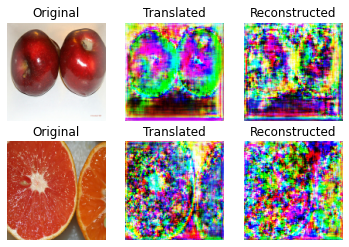

In [9]:
from google.colab import drive
drive.mount('/content/drive')

datasetname = 'apple2orange'
dataset, metadata = tfds.load('cycle_gan/%s' %datasetname,
                              with_info=True, as_supervised=True)

# 직접 사이트서 다운로드 방법
# https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/

cycle_gan = CycleGAN(dataset)
cycle_gan.train(epochs=400, batch_size=64, sample_interval=20)